# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from datetime import datetime

# Set style for better visuals
plt.style.use('seaborn')

/tmp/ipykernel_16981/3166615292.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Dataset Loading

In [2]:
df = pd.read_csv('./dataset/bustabit.csv')

# EDA

In [3]:
df.head()

,Id,GameID,Username,Bet,CashedOut,Bonus,Profit,BustedAt,PlayDate
0,14196549,3366002,papai,5,1.20,0.0,1.00,8.24,2016-11-20T19:44:19Z
1,10676217,3343882,znay22,3,NaN,NaN,NaN,1.40,2016-11-14T14:21:50Z
2,15577107,3374646,rrrrrrrr,4,1.33,3.0,1.44,3.15,2016-11-23T06:39:15Z
3,25732127,3429241,sanya1206,10,NaN,NaN,NaN,1.63,2016-12-08T18:13:55Z
4,17995432,3389174,ADM,50,1.50,1.4,25.70,2.29,2016-11-27T08:14:48Z


# Replacing NaN Values with 0 in DataFrame

In [4]:
df.fillna(0, inplace=True)

In [5]:
df.head()

,Id,GameID,Username,Bet,CashedOut,Bonus,Profit,BustedAt,PlayDate
0,14196549,3366002,papai,5,1.20,0.0,1.00,8.24,2016-11-20T19:44:19Z
1,10676217,3343882,znay22,3,0.00,0.0,0.00,1.40,2016-11-14T14:21:50Z
2,15577107,3374646,rrrrrrrr,4,1.33,3.0,1.44,3.15,2016-11-23T06:39:15Z
3,25732127,3429241,sanya1206,10,0.00,0.0,0.00,1.63,2016-12-08T18:13:55Z
4,17995432,3389174,ADM,50,1.50,1.4,25.70,2.29,2016-11-27T08:14:48Z


# Target Variable Creation

In [6]:
# Convert 'PlayDate' to datetime
df['PlayDate'] = pd.to_datetime(df['PlayDate'])

# Find the last date in the dataset
latest_date = df['PlayDate'].max()

# Group by player and find their last activity date
player_churn_activity = df.groupby('Username')['PlayDate'].max().reset_index()

# Define churn threshold (e.g., 30 days)
churn_threshold_days = 6
player_churn_activity['Churned'] = (
    (latest_date - player_churn_activity['PlayDate']) > pd.Timedelta(days=churn_threshold_days)
).astype(int)

In [7]:
churn_counts = player_churn_activity['Churned'].value_counts()
print(churn_counts)

Churned
1    2962
0    1187
Name: count, dtype: int64


In [8]:
# Merge churn status with original data
df = df.merge(player_churn_activity[['Username', 'Churned']], on='Username')

In [9]:
df.head(5)

,Id,GameID,Username,Bet,CashedOut,Bonus,Profit,BustedAt,PlayDate,Churned
0,14196549,3366002,papai,5,1.20,0.0,1.00,8.24,2016-11-20 19:44:19+00:00,1
1,14371418,3367200,papai,5,1.20,3.0,1.15,1.20,2016-11-21 03:51:34+00:00,1
2,14306198,3366697,papai,5,0.00,0.0,0.00,1.16,2016-11-21 00:28:45+00:00,1
3,15842561,3376103,papai,1,1.05,3.0,0.08,1.70,2016-11-23 16:31:24+00:00,1
4,13098255,3358777,papai,20,1.20,0.0,4.00,3.43,2016-11-18 18:57:36+00:00,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   Id         50000 non-null  int64              
 1   GameID     50000 non-null  int64              
 2   Username   50000 non-null  object             
 3   Bet        50000 non-null  int64              
 4   CashedOut  50000 non-null  float64            
 5   Bonus      50000 non-null  float64            
 6   Profit     50000 non-null  float64            
 7   BustedAt   50000 non-null  float64            
 8   PlayDate   50000 non-null  datetime64[ns, UTC]
 9   Churned    50000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(4), object(1)
memory usage: 3.8+ MB


# Feature Engineering

In [11]:
# Step 1: Get the last, second-last, and third-last play dates per player

player_activity = (
    df.sort_values('PlayDate')
    .groupby('Username')['PlayDate']
    .agg([
        ('LastPlayDate', 'last'),  # Most recent play (always exists)
        ('SecondLastPlayDate', lambda x: x.iloc[-2] if len(x) >= 2 else pd.NaT),
        ('ThirdLastPlayDate', lambda x: x.iloc[-3] if len(x) >= 3 else pd.NaT)
    ])
    .reset_index()
)

# Calculate days with fillna(0) at the end
player_activity['DaysSinceLastPlay'] = (latest_date - player_activity['LastPlayDate']).dt.days
player_activity['DaysSinceSecondLastPlay'] = (latest_date - player_activity['SecondLastPlayDate']).dt.days.fillna(0)
player_activity['DaysSinceThirdLastPlay'] = (latest_date - player_activity['ThirdLastPlayDate']).dt.days.fillna(0)

In [12]:
player_activity.head(5)

,Username,LastPlayDate,SecondLastPlayDate,ThirdLastPlayDate,DaysSinceLastPlay,DaysSinceSecondLastPlay,DaysSinceThirdLastPlay
0,----------------,2016-11-03 20:26:24+00:00,2016-11-03 15:05:40+00:00,2016-11-03 06:14:27+00:00,36,37.0,37.0
1,--dilib--,2016-11-03 17:35:53+00:00,2016-11-03 08:48:12+00:00,2016-11-03 08:39:20+00:00,37,37.0,37.0
2,-31337-,2016-12-09 20:33:22+00:00,2016-12-09 19:56:00+00:00,2016-12-09 18:31:58+00:00,0,1.0,1.0
3,-Nothing-,2016-12-06 15:27:27+00:00,2016-12-06 15:01:15+00:00,2016-11-24 19:07:24+00:00,4,4.0,16.0
4,-Tachyon,2016-11-01 23:10:05+00:00,2016-11-01 22:50:26+00:00,2016-11-01 11:17:05+00:00,38,38.0,39.0


In [13]:
# Define the time windows (in days)
#time_windows = [4, 8, 12, 16, 20, 24, 28, 32, 36]
time_windows = [6, 12, 18, 24, 30, 36]
# Initialize a DataFrame to store results
player_bets_by_window = df[['Username']].drop_duplicates()

# Calculate bet sums for each time window
for days in time_windows:
    # Calculate cutoff date
    cutoff_date = latest_date - pd.Timedelta(days=days)
    
    # Filter bets and sum by player
    window_bets = (
        df[df['PlayDate'] >= cutoff_date]
        .groupby('Username')['Bet']
        .sum()
        .reset_index()
        .rename(columns={'Bet': f'BetsLast{days}Days'})
    )
    
    # Merge with main DataFrame
    player_bets_by_window = player_bets_by_window.merge(
        window_bets,
        on='Username',
        how='left'
    )

# Fill NA with 0 (for players with no bets in a window)
player_bets_by_window = player_bets_by_window.fillna(0)


In [14]:
player_bets_by_window.head()

,Username,BetsLast6Days,BetsLast12Days,BetsLast18Days,BetsLast24Days,BetsLast30Days,BetsLast36Days
0,papai,0.0,0.0,1.0,227.0,227.0,227.0
1,znay22,968.0,1092.0,1391.0,2097.0,2235.0,2663.0
2,rrrrrrrr,68.0,68.0,1372.0,2458.0,2458.0,2458.0
3,sanya1206,180.0,180.0,180.0,180.0,180.0,180.0
4,ADM,5338.0,13388.0,13646.0,13646.0,13646.0,14575.0


In [15]:
player_bets_by_window.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149 entries, 0 to 4148
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Username        4149 non-null   object 
 1   BetsLast6Days   4149 non-null   float64
 2   BetsLast12Days  4149 non-null   float64
 3   BetsLast18Days  4149 non-null   float64
 4   BetsLast24Days  4149 non-null   float64
 5   BetsLast30Days  4149 non-null   float64
 6   BetsLast36Days  4149 non-null   float64
dtypes: float64(6), object(1)
memory usage: 227.0+ KB


In [16]:
player_last_activity = player_bets_by_window.merge(player_activity[['Username', 'DaysSinceLastPlay', 'DaysSinceSecondLastPlay', 'DaysSinceThirdLastPlay']], on='Username')

In [17]:
player_stats = df.groupby('Username').agg(
    TotalBetAmount=('Bet', 'sum'),
    TotalProfitAmount=('Profit', 'sum'),
    TotalBonusAmount=('Bonus', 'sum'),
    NumberOfBets=('Bet', 'count'),
    NumberOfBets_Won=('Profit', lambda x: (x > 0).sum()),  # Count wins (Profit > 0)
    NumberOfBets_Lost=('Profit', lambda x: (x <= 0).sum()), # Count losses (Profit <= 0)
    AverageBet=('Bet', 'mean'),
    MaxBet=('Bet', 'max'),
    MinBet=('Bet', 'min'),
    Churned=('Churned', 'first'),
).reset_index().sort_values('TotalBetAmount', ascending=False)

In [18]:
columns_to_select = [col for col in player_bets_by_window.columns ]
columns_to_select

['Username',
 'BetsLast6Days',
 'BetsLast12Days',
 'BetsLast18Days',
 'BetsLast24Days',
 'BetsLast30Days',
 'BetsLast36Days']

In [19]:
# Merge churn status with original data
final_df = player_stats.merge(player_last_activity[columns_to_select], on='Username')
#final_df = player_stats.merge(player_last_activity[['Username', 'BetsLast4Days','BetsLast8Days','BetsLast12Days','BetsLast16Days','BetsLast20Days','BetsLast24Days','BetsLast28Days','BetsLast32Days','BetsLast36Days', 'DaysSinceLastPlay','DaysSinceSecondLastPlay','DaysSinceThirdLastPlay']], on='Username')

In [20]:
final_df.head(10)

,Username,TotalBetAmount,TotalProfitAmount,TotalBonusAmount,NumberOfBets,NumberOfBets_Won,NumberOfBets_Lost,AverageBet,MaxBet,MinBet,Churned,BetsLast6Days,BetsLast12Days,BetsLast18Days,BetsLast24Days,BetsLast30Days,BetsLast36Days
0,allg1124,16262350,4794154.34,85.12,101,74,27,161013.366337,1000000,39,0,10718.0,10835.0,70835.0,7982234.0,13482234.0,15466330.0
1,Alexy,12216534,2421114.49,16.36,47,22,25,259926.255319,1000000,4371,0,7118027.0,12175954.0,12216534.0,12216534.0,12216534.0,12216534.0
2,stevemoley,6173301,328758.17,15.56,25,22,3,246932.040000,1000000,1301,0,584000.0,584000.0,1634000.0,3902000.0,5106301.0,6173301.0
3,zabby,5503821,562907.44,11.24,30,23,7,183460.700000,988571,8,0,934401.0,1260251.0,2516750.0,3484750.0,4352250.0,4425250.0
4,goosin2000,4469000,3803213.87,16.77,19,8,11,235210.526316,550000,70000,1,0.0,0.0,979000.0,2779000.0,3079000.0,3549000.0
5,maras,2628100,313451.23,17.32,24,15,9,109504.166667,509000,13000,1,0.0,0.0,0.0,0.0,694500.0,1271000.0
6,period,2561200,196276.45,11.46,9,6,3,284577.777778,500000,32500,1,0.0,0.0,2561200.0,2561200.0,2561200.0,2561200.0
7,rickette,2170100,222161.56,21.51,18,13,5,120561.111111,892000,24000,1,0.0,1087900.0,2170100.0,2170100.0,2170100.0,2170100.0
8,goldman1,2146508,1271746.51,9.06,12,4,8,178875.666667,450000,6584,0,256508.0,256508.0,1496508.0,1896508.0,1896508.0,2146508.0
9,hindoong,2064000,65784.40,1.45,3,3,0,688000.000000,1000000,64000,0,2064000.0,2064000.0,2064000.0,2064000.0,2064000.0,2064000.0


# Correlation Heatmap

In [21]:
final_df_corr = final_df.drop(['Username'], axis=1)

In [22]:
import seaborn as sns
# Calculate correlation matrix
corr_matrix = final_df_corr.corr()

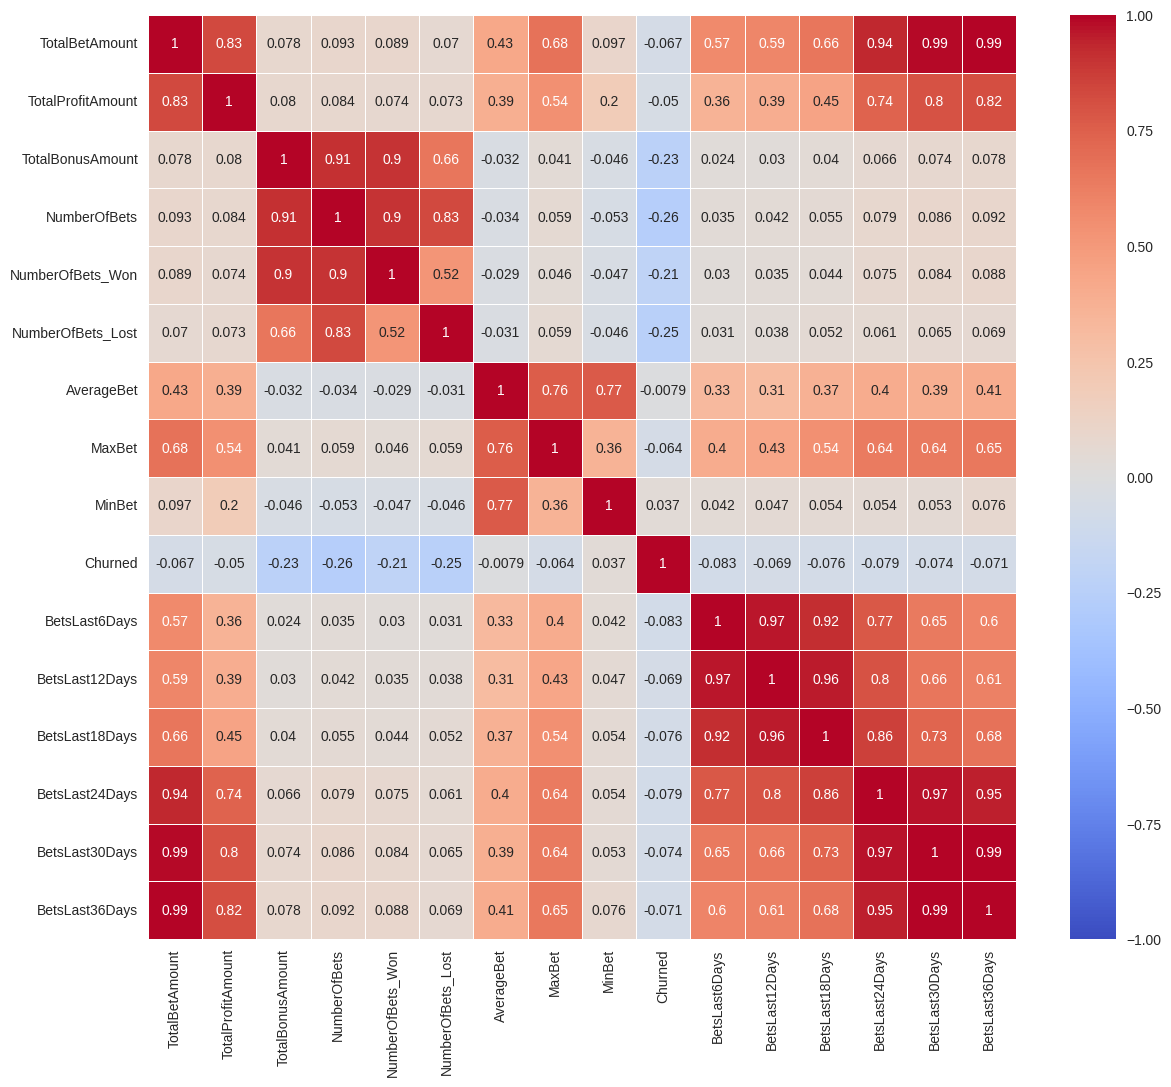

In [23]:
# Create a heatmap
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(
    corr_matrix, 
    annot=True,  # Show correlation values in cells
    cmap='coolwarm',  # Color scheme
    vmin=-1, vmax=1,  # Set scale from -1 to 1
    linewidths=0.5,
    annot_kws={'size': 10}
)

# Before Scale the data histogram

In [24]:
# Assuming `data` is your DataFrame and 'churned' is binary (0 or 1)
numerical_features = final_df_corr.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove('Churned')  # Exclude target if numerical

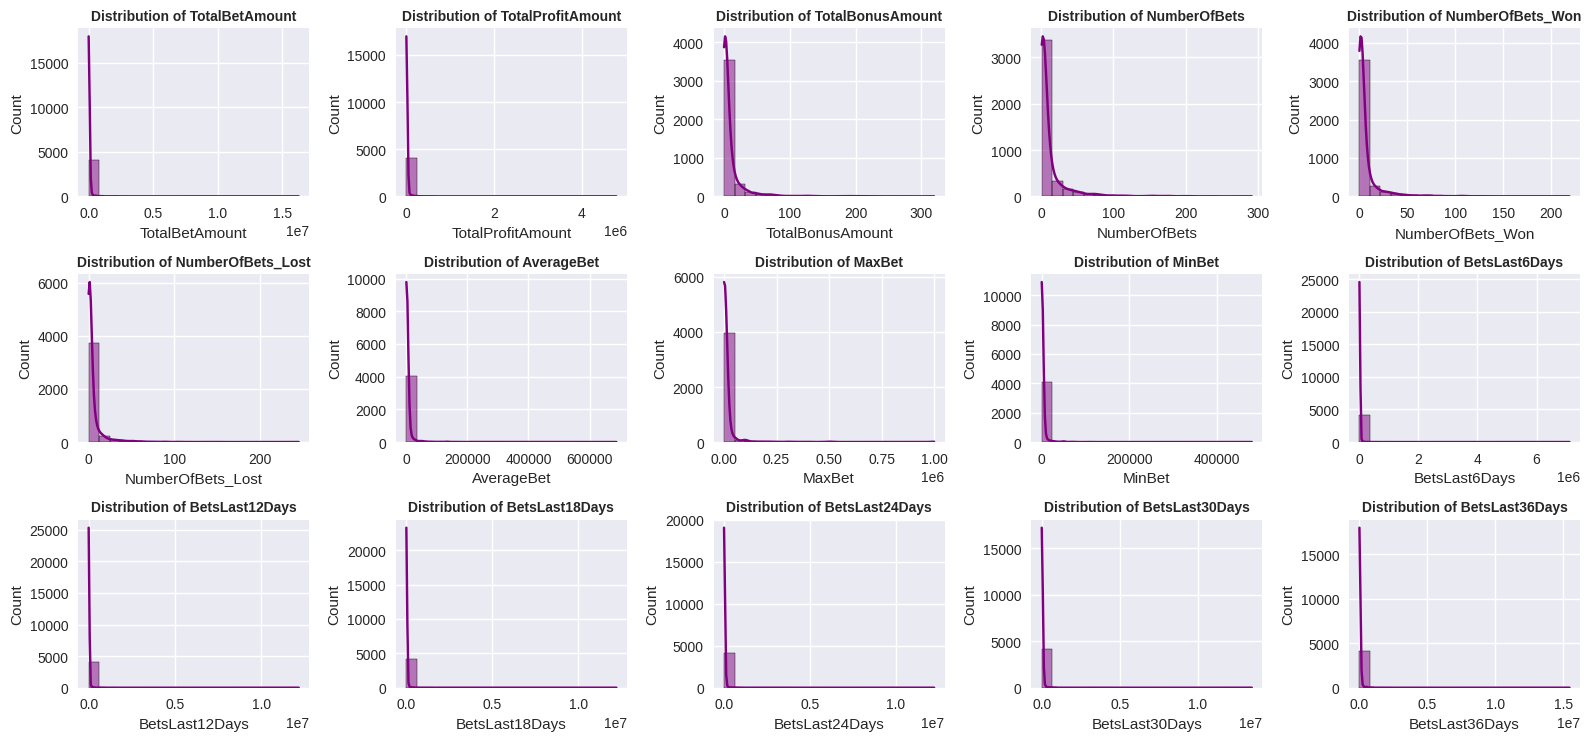

In [25]:
# Plot histograms for all numerical features
plt.figure(figsize=(16, 12))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(5, 5, i)  # Adjust grid size as needed
    sns.histplot(data=final_df_corr, x=feature, kde=True, bins=20, color='purple')
    plt.title(f'Distribution of {feature}', fontsize=10, weight='bold')
plt.tight_layout()
plt.show()

# Log Transform before scale data

In [26]:
final_df_transform = final_df_corr.drop(['Churned'], axis=1)

In [27]:
final_df_transform.head()

,TotalBetAmount,TotalProfitAmount,TotalBonusAmount,NumberOfBets,NumberOfBets_Won,NumberOfBets_Lost,AverageBet,MaxBet,MinBet,BetsLast6Days,BetsLast12Days,BetsLast18Days,BetsLast24Days,BetsLast30Days,BetsLast36Days
0,16262350,4794154.34,85.12,101,74,27,161013.366337,1000000,39,10718.0,10835.0,70835.0,7982234.0,13482234.0,15466330.0
1,12216534,2421114.49,16.36,47,22,25,259926.255319,1000000,4371,7118027.0,12175954.0,12216534.0,12216534.0,12216534.0,12216534.0
2,6173301,328758.17,15.56,25,22,3,246932.040000,1000000,1301,584000.0,584000.0,1634000.0,3902000.0,5106301.0,6173301.0
3,5503821,562907.44,11.24,30,23,7,183460.700000,988571,8,934401.0,1260251.0,2516750.0,3484750.0,4352250.0,4425250.0
4,4469000,3803213.87,16.77,19,8,11,235210.526316,550000,70000,0.0,0.0,979000.0,2779000.0,3079000.0,3549000.0


In [28]:
final_df_transform = np.log1p(final_df_transform)

In [29]:
# Assuming `data` is your DataFrame and 'churned' is binary (0 or 1)
numerical_features = final_df_transform.select_dtypes(include=['int64', 'float64']).columns.tolist()
#numerical_features.remove('Churned')  # Exclude target if numerical

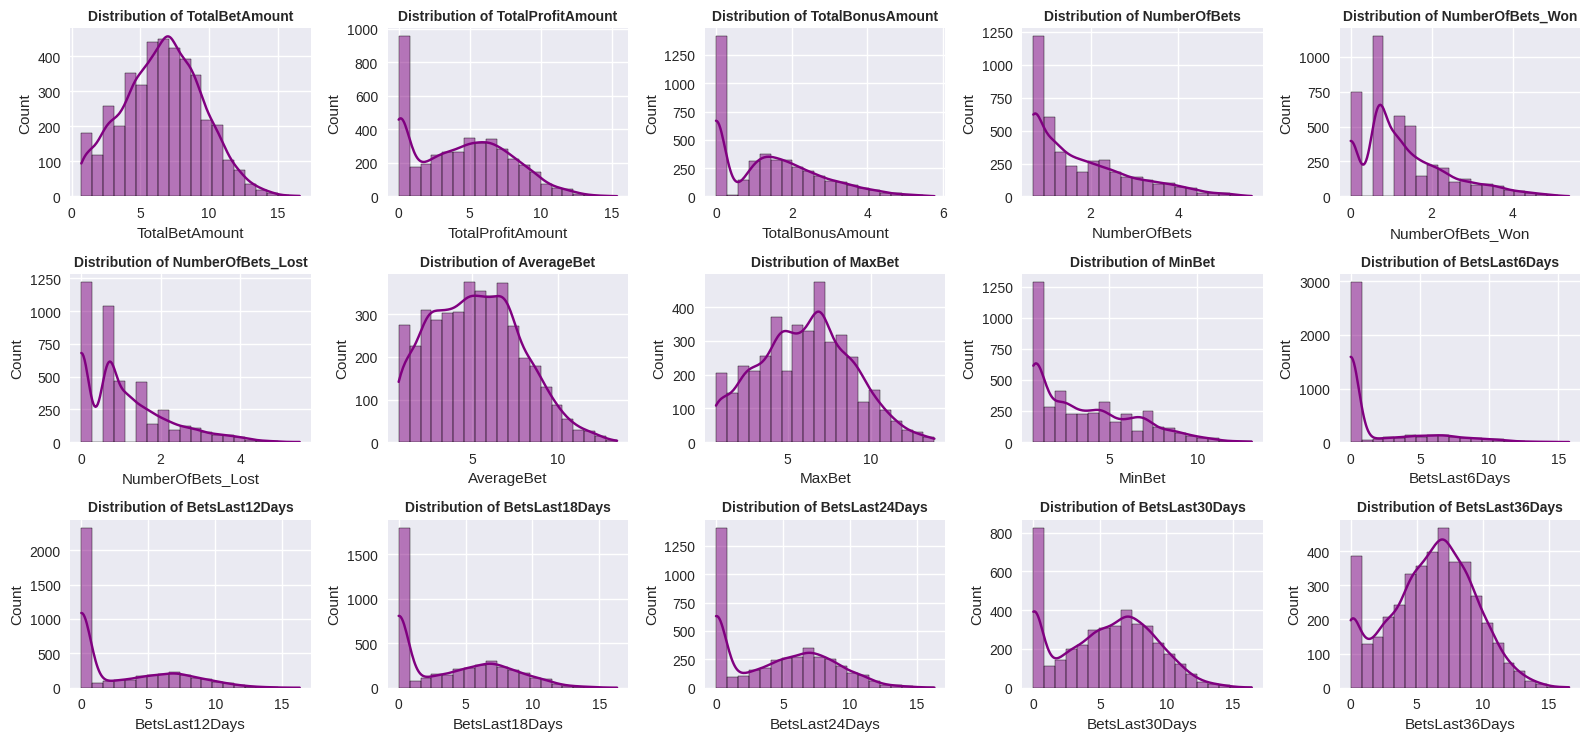

In [30]:
# Plot histograms for all numerical features
plt.figure(figsize=(16, 12))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(5, 5, i)  # Adjust grid size as needed
    sns.histplot(data=final_df_transform, x=feature, kde=True, bins=20, color='purple')
    plt.title(f'Distribution of {feature}', fontsize=10, weight='bold')
plt.tight_layout()
plt.show()

# Scale the data before training

In [31]:
feature_df = final_df_corr.drop(['Churned'],axis=1)
list_of_features = [col for col in feature_df.columns ]
list_of_features

['TotalBetAmount',
 'TotalProfitAmount',
 'TotalBonusAmount',
 'NumberOfBets',
 'NumberOfBets_Won',
 'NumberOfBets_Lost',
 'AverageBet',
 'MaxBet',
 'MinBet',
 'BetsLast6Days',
 'BetsLast12Days',
 'BetsLast18Days',
 'BetsLast24Days',
 'BetsLast30Days',
 'BetsLast36Days']

In [32]:
# cols_to_scale = ['TotalBetAmount','TotalProfitAmount','TotalBonusAmount',
#                  'NumberOfBets','NumberOfBets_Won','NumberOfBets_Lost','AverageBet',
#                  'MaxBet','MinBet', 'BetsLast4Days','BetsLast8Days','BetsLast12Days','BetsLast16Days',
#                  'BetsLast20Days','BetsLast24Days','BetsLast28Days','BetsLast32Days','BetsLast36Days',
#                  'DaysSinceLastPlay','DaysSinceSecondLastPlay','DaysSinceThirdLastPlay']

cols_to_scale = list_of_features

In [33]:
from sklearn.preprocessing import MinMaxScaler

In [34]:
scaler = MinMaxScaler()

In [35]:
#final_df[cols_to_scale] = scaler.fit_transform(final_df[cols_to_scale])
final_df_transform[cols_to_scale] = scaler.fit_transform(final_df_transform[cols_to_scale])

In [36]:
final_df_transform.head(5)

,TotalBetAmount,TotalProfitAmount,TotalBonusAmount,NumberOfBets,NumberOfBets_Won,NumberOfBets_Lost,AverageBet,MaxBet,MinBet,BetsLast6Days,BetsLast12Days,BetsLast18Days,BetsLast24Days,BetsLast30Days,BetsLast36Days
0,1.000000,1.000000,0.772383,0.788952,0.800479,0.605269,0.886080,1.000000,0.241818,0.588141,0.569454,0.684392,0.973921,1.000000,1.000000
1,0.982021,0.955589,0.494758,0.637702,0.581333,0.591808,0.923646,1.000000,0.620728,1.000000,1.000000,1.000000,1.000000,0.993995,0.985751
2,0.939124,0.825792,0.486580,0.514677,0.581333,0.251809,0.919623,1.000000,0.522950,0.841522,0.813833,0.876718,0.930060,0.940860,0.944520
3,0.931909,0.860752,0.434180,0.549971,0.589224,0.377714,0.896318,0.999124,0.121410,0.871311,0.860977,0.903187,0.923130,0.931127,0.924409
4,0.918819,0.984948,0.498804,0.462032,0.407374,0.451364,0.915809,0.954441,0.844590,0.000000,0.000000,0.845326,0.909261,0.910046,0.911080


# Separate Features

In [37]:
#features = final_df.drop(['Username', 'Churned'], axis=1)
features = final_df_transform

# Separate Labels

In [38]:
labels = final_df['Churned']

In [39]:
X = features
y = labels

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

In [42]:
X_train[:10]

,TotalBetAmount,TotalProfitAmount,TotalBonusAmount,NumberOfBets,NumberOfBets_Won,NumberOfBets_Lost,AverageBet,MaxBet,MinBet,BetsLast6Days,BetsLast12Days,BetsLast18Days,BetsLast24Days,BetsLast30Days,BetsLast36Days
3462,0.181656,0.192260,0.477004,0.220445,0.257024,0.199554,0.108743,0.201111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.216472
1059,0.494209,0.000000,0.000000,0.081360,0.000000,0.199554,0.562463,0.562252,0.557639,0.000000,0.000000,0.524356,0.524356,0.521208,0.516885
3267,0.220696,0.205641,0.387678,0.081360,0.203687,0.000000,0.222241,0.265291,0.032729,0.000000,0.000000,0.000000,0.000000,0.000000,0.252165
1559,0.434175,0.000000,0.000000,0.000000,0.000000,0.125905,0.541892,0.526449,0.557639,0.000000,0.000000,0.000000,0.465821,0.463023,0.459183
2907,0.273410,0.148504,0.512221,0.429421,0.502083,0.199554,0.131002,0.129912,0.073964,0.000000,0.000000,0.000000,0.000000,0.307210,0.304662
690,0.546759,0.000000,0.000000,0.000000,0.000000,0.125905,0.682407,0.662960,0.702238,0.595301,0.575713,0.575596,0.575596,0.572139,0.567394
3750,0.112610,0.107549,0.158835,0.220445,0.128512,0.292342,0.036868,0.052822,0.032729,0.157490,0.152308,0.152277,0.152277,0.151363,0.150108
2073,0.384028,0.298552,0.375996,0.220445,0.332199,0.000000,0.353405,0.420919,0.316584,0.000000,0.000000,0.000000,0.000000,0.414421,0.410984
3917,0.069046,0.032554,0.000000,0.000000,0.128512,0.000000,0.086176,0.083721,0.088681,0.000000,0.000000,0.000000,0.000000,0.109141,0.108236
1844,0.398317,0.593343,0.418633,0.081360,0.203687,0.000000,0.442836,0.480921,0.221243,0.000000,0.000000,0.000000,0.000000,0.426632,0.423094


# Implementing ANN model

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Initialize model
model = Sequential()

# Input layer + first hidden layer
model.add(Dense(units=4, activation='relu', input_dim=X_train.shape[1])) # before unit was 64
model.add(Dropout(0.2))  # Regularization

# Second hidden layer
#model.add(Dense(units=2, activation='relu')) # before unit was 32
#model.add(Dropout(0.2))

# Output layer (sigmoid for binary classification)
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

2025-07-09 01:47:57.879285: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-09 01:47:58.085398: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-09 01:48:00.495232: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 64        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 69 (276.00 Byte)
Trainable params: 69 (276.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=3,  # previously 100
    batch_size=2, # previously 32
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/3
1660/1660 [==============================] - 10s 5ms/step - loss: 0.4541 - accuracy: 0.8445 - val_loss: 0.2458 - val_accuracy: 0.9530
Epoch 2/3
1660/1660 [==============================] - 7s 4ms/step - loss: 0.2104 - accuracy: 0.9412 - val_loss: 0.1154 - val_accuracy: 0.9795
Epoch 3/3
1660/1660 [==============================] - 7s 4ms/step - loss: 0.1377 - accuracy: 0.9602 - val_loss: 0.0719 - val_accuracy: 0.9916


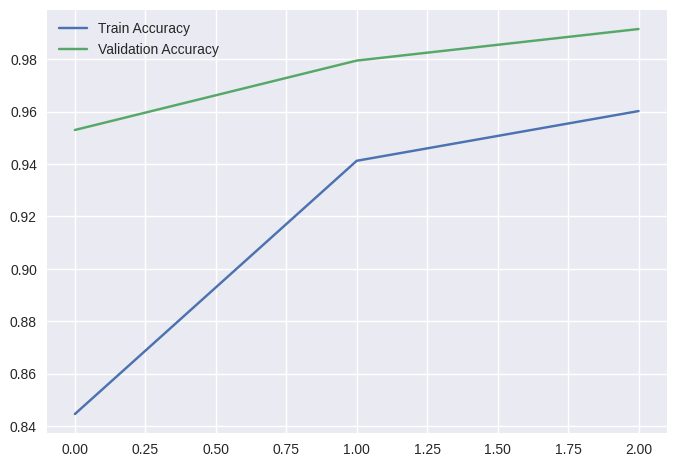

26/26 [==============================] - 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98       226
           1       0.99      1.00      0.99       604

    accuracy                           0.99       830
   macro avg       0.99      0.98      0.99       830
weighted avg       0.99      0.99      0.99       830

Confusion Matrix:
 [[219   7]
 [  0 604]]


In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Predictions (convert probabilities to binary)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [46]:
import tensorflow as tf
from tensorflow import keras

Text(95.72222222222221, 0.5, 'Truth')

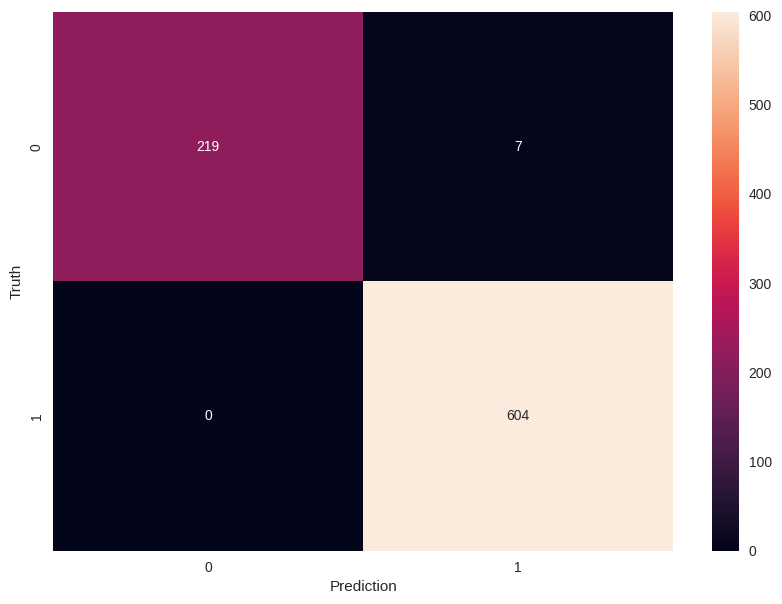

In [47]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

plt.figure(figsize= (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

# Class count

In [48]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149 entries, 0 to 4148
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Username           4149 non-null   object 
 1   TotalBetAmount     4149 non-null   int64  
 2   TotalProfitAmount  4149 non-null   float64
 3   TotalBonusAmount   4149 non-null   float64
 4   NumberOfBets       4149 non-null   int64  
 5   NumberOfBets_Won   4149 non-null   int64  
 6   NumberOfBets_Lost  4149 non-null   int64  
 7   AverageBet         4149 non-null   float64
 8   MaxBet             4149 non-null   int64  
 9   MinBet             4149 non-null   int64  
 10  Churned            4149 non-null   int64  
 11  BetsLast6Days      4149 non-null   float64
 12  BetsLast12Days     4149 non-null   float64
 13  BetsLast18Days     4149 non-null   float64
 14  BetsLast24Days     4149 non-null   float64
 15  BetsLast30Days     4149 non-null   float64
 16  BetsLast36Days     4149 

In [49]:
count_class_0, count_class_1 = final_df.Churned.value_counts()

In [50]:
count_class_0, count_class_1

(2962, 1187)

In [51]:
df_class_0 = final_df[final_df['Churned'] == 1 ]
df_class_1 = final_df[final_df['Churned'] == 0 ]

In [52]:
df_class_0.shape

(2962, 17)

In [53]:
df_class_1.shape

(1187, 17)

# Under Sampling

In [54]:
df_class_0_under = df_class_0.sample(count_class_1, replace=True)

In [55]:
df_class_0_under.shape

(1187, 17)

In [56]:
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

In [57]:
df_test_under.shape

(2374, 17)

In [58]:
print('Random Under Sampling')
print(df_test_under.Churned.value_counts())

Random Under Sampling
Churned
1    1187
0    1187
Name: count, dtype: int64


In [59]:
df_test_under.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2374 entries, 194 to 4140
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Username           2374 non-null   object 
 1   TotalBetAmount     2374 non-null   int64  
 2   TotalProfitAmount  2374 non-null   float64
 3   TotalBonusAmount   2374 non-null   float64
 4   NumberOfBets       2374 non-null   int64  
 5   NumberOfBets_Won   2374 non-null   int64  
 6   NumberOfBets_Lost  2374 non-null   int64  
 7   AverageBet         2374 non-null   float64
 8   MaxBet             2374 non-null   int64  
 9   MinBet             2374 non-null   int64  
 10  Churned            2374 non-null   int64  
 11  BetsLast6Days      2374 non-null   float64
 12  BetsLast12Days     2374 non-null   float64
 13  BetsLast18Days     2374 non-null   float64
 14  BetsLast24Days     2374 non-null   float64
 15  BetsLast30Days     2374 non-null   float64
 16  BetsLast36Days     2374 non

In [60]:
under_sampling_df = df_test_under.drop(['Username','Churned'], axis=1)

In [61]:
under_sampling_df.head()

,TotalBetAmount,TotalProfitAmount,TotalBonusAmount,NumberOfBets,NumberOfBets_Won,NumberOfBets_Lost,AverageBet,MaxBet,MinBet,BetsLast6Days,BetsLast12Days,BetsLast18Days,BetsLast24Days,BetsLast30Days,BetsLast36Days
194,95615,11418.53,6.53,4,4,0,23903.75,78500,275,0.0,0.0,0.0,78500.0,78500.0,90060.0
4037,2,2.03,3.00,2,2,0,1.00,1,1,0.0,0.0,2.0,2.0,2.0,2.0
817,9114,5169.04,29.31,30,13,17,303.80,1944,32,0.0,3420.0,8114.0,9114.0,9114.0,9114.0
3549,25,0.25,0.00,1,1,0,25.00,25,25,0.0,0.0,0.0,0.0,0.0,25.0
3999,3,1.59,6.50,2,2,0,1.50,2,1,0.0,0.0,0.0,3.0,3.0,3.0


In [62]:
under_sampling_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2374 entries, 194 to 4140
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TotalBetAmount     2374 non-null   int64  
 1   TotalProfitAmount  2374 non-null   float64
 2   TotalBonusAmount   2374 non-null   float64
 3   NumberOfBets       2374 non-null   int64  
 4   NumberOfBets_Won   2374 non-null   int64  
 5   NumberOfBets_Lost  2374 non-null   int64  
 6   AverageBet         2374 non-null   float64
 7   MaxBet             2374 non-null   int64  
 8   MinBet             2374 non-null   int64  
 9   BetsLast6Days      2374 non-null   float64
 10  BetsLast12Days     2374 non-null   float64
 11  BetsLast18Days     2374 non-null   float64
 12  BetsLast24Days     2374 non-null   float64
 13  BetsLast30Days     2374 non-null   float64
 14  BetsLast36Days     2374 non-null   float64
dtypes: float64(9), int64(6)
memory usage: 296.8 KB


In [63]:
under_sampling_df.shape

(2374, 15)

In [64]:
# Assuming `data` is your DataFrame and 'churned' is binary (0 or 1)
numerical_features = under_sampling_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
#numerical_features.remove('Username')  # Exclude target if numerical
#numerical_features.remove('Churned')  # Exclude target if numerical


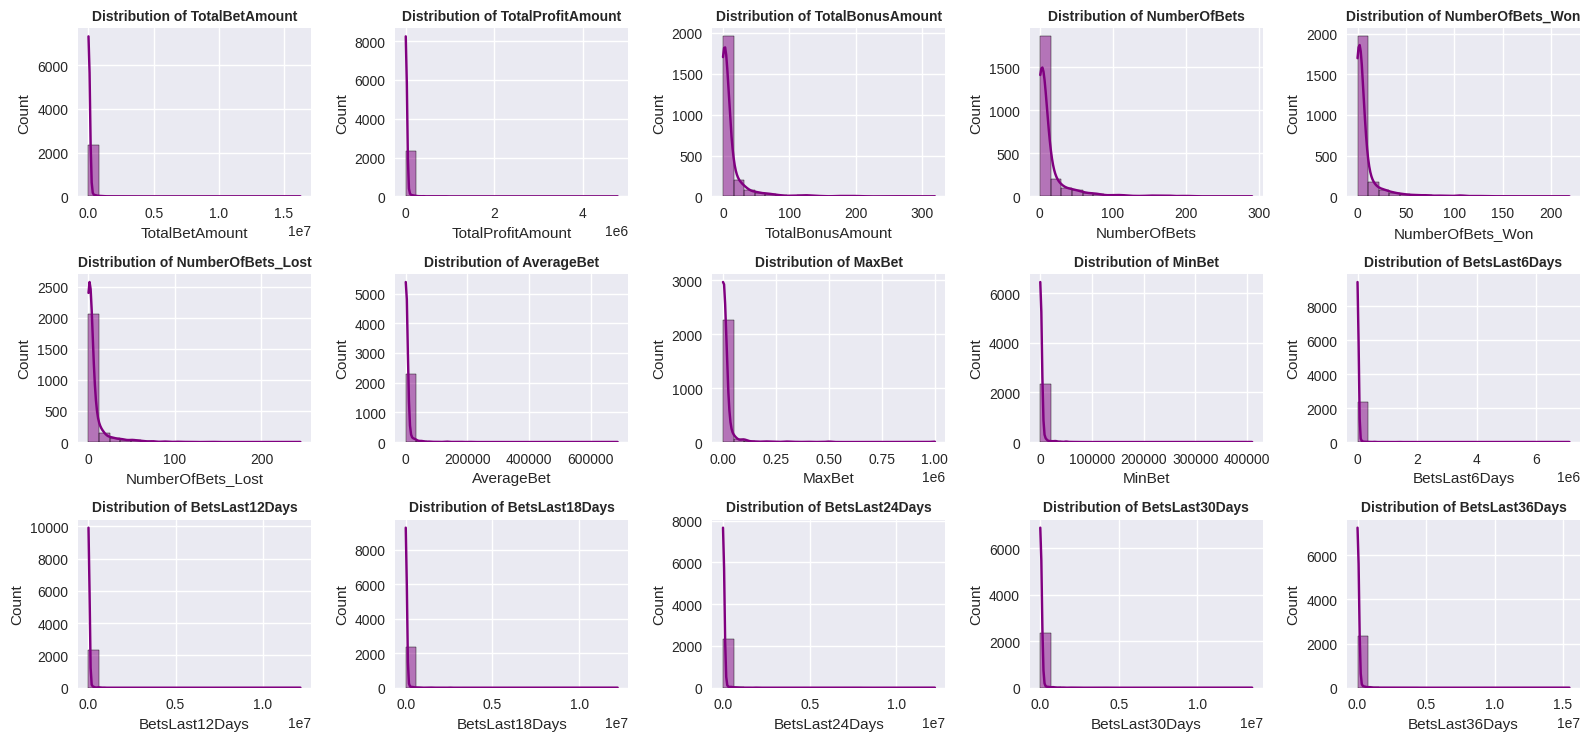

In [65]:
# Plot histograms for all numerical features
plt.figure(figsize=(16, 12))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(5, 5, i)  # Adjust grid size as needed
    sns.histplot(data=under_sampling_df, x=feature, kde=True, bins=20, color='purple')
    plt.title(f'Distribution of {feature}', fontsize=10, weight='bold')
plt.tight_layout()
plt.show()

# log transform the data

In [66]:
#under_sampling_df = df_test_under.drop(['Username','Churned'], axis=1)
under_sampling_df_transform = np.log1p(under_sampling_df)

In [67]:
numerical_features = under_sampling_df_transform.select_dtypes(include=['int64', 'float64']).columns.tolist()

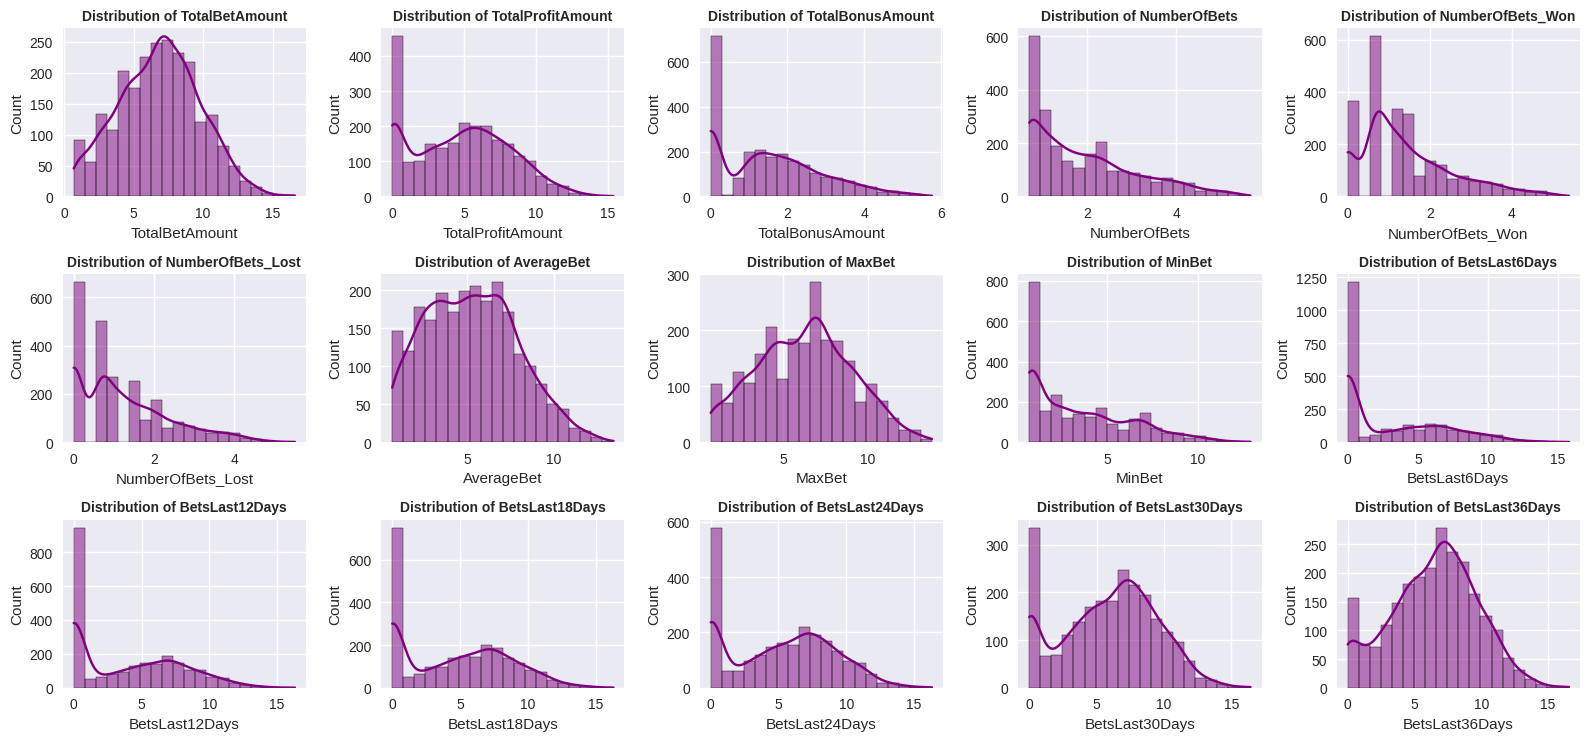

In [68]:
# Plot histograms for all numerical features
plt.figure(figsize=(16, 12))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(5, 5, i)  # Adjust grid size as needed
    sns.histplot(data=under_sampling_df_transform, x=feature, kde=True, bins=20, color='purple')
    plt.title(f'Distribution of {feature}', fontsize=10, weight='bold')
plt.tight_layout()
plt.show()

In [69]:
# cols_to_scale = ['TotalBetAmount','TotalProfitAmount','TotalBonusAmount',
#                  'NumberOfBets','NumberOfBets_Won','NumberOfBets_Lost','AverageBet',
#                  'MaxBet','MinBet', 'BetsLast4Days','BetsLast8Days','BetsLast12Days','BetsLast16Days',
#                  'BetsLast20Days','BetsLast24Days','BetsLast28Days','BetsLast32Days','BetsLast36Days',
#                  'DaysSinceLastPlay','DaysSinceSecondLastPlay','DaysSinceThirdLastPlay']

cols_to_scale = list_of_features

In [70]:
under_sampling_df_transform[cols_to_scale] = scaler.fit_transform(under_sampling_df_transform[cols_to_scale])

In [71]:
X = under_sampling_df_transform
y = df_test_under['Churned']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

In [73]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=3,  # previously 100
    batch_size=2, # previously 32
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/3
950/950 [==============================] - 7s 7ms/step - loss: 0.1293 - accuracy: 0.9526 - val_loss: 0.0788 - val_accuracy: 0.9853
Epoch 2/3
950/950 [==============================] - 7s 7ms/step - loss: 0.1144 - accuracy: 0.9595 - val_loss: 0.0674 - val_accuracy: 0.9895
Epoch 3/3
950/950 [==============================] - 7s 7ms/step - loss: 0.0987 - accuracy: 0.9605 - val_loss: 0.0593 - val_accuracy: 0.9916


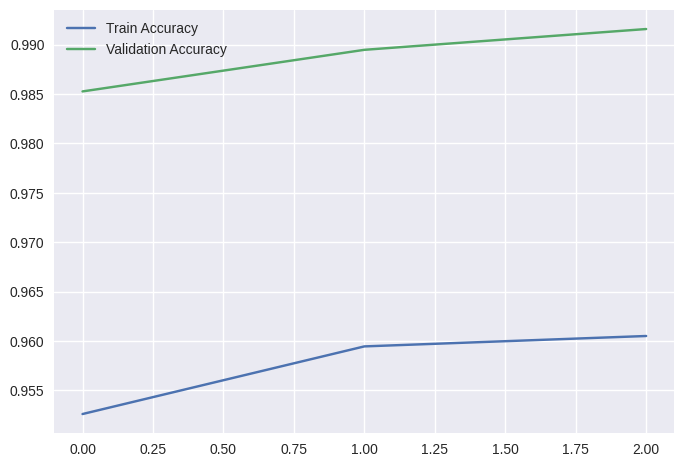

15/15 [==============================] - 0s 4ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       234
           1       0.98      1.00      0.99       241

    accuracy                           0.99       475
   macro avg       0.99      0.99      0.99       475
weighted avg       0.99      0.99      0.99       475

Confusion Matrix:
 [[230   4]
 [  0 241]]


In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Predictions (convert probabilities to binary)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Text(95.72222222222221, 0.5, 'Truth')

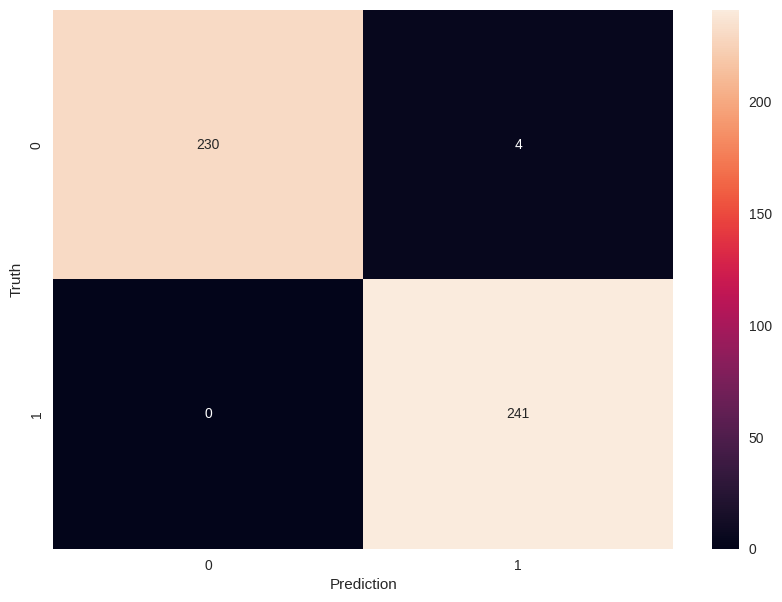

In [75]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

plt.figure(figsize= (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

# Over Sampling

In [76]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over],axis=0)

In [77]:
df_class_1_over.shape

(2962, 17)

In [78]:
df_test_over.shape

(5924, 17)

In [79]:
print('Random over-sampling:')
print(df_test_over.Churned.value_counts())

Random over-sampling:
Churned
1    2962
0    2962
Name: count, dtype: int64


In [80]:
over_sampling_df = df_test_over.drop(['Username','Churned'], axis=1)

In [81]:
over_sampling_df.head()

,TotalBetAmount,TotalProfitAmount,TotalBonusAmount,NumberOfBets,NumberOfBets_Won,NumberOfBets_Lost,AverageBet,MaxBet,MinBet,BetsLast6Days,BetsLast12Days,BetsLast18Days,BetsLast24Days,BetsLast30Days,BetsLast36Days
4,4469000,3803213.87,16.77,19,8,11,235210.526316,550000,70000,0.0,0.0,979000.0,2779000.0,3079000.0,3549000.0
5,2628100,313451.23,17.32,24,15,9,109504.166667,509000,13000,0.0,0.0,0.0,0.0,694500.0,1271000.0
6,2561200,196276.45,11.46,9,6,3,284577.777778,500000,32500,0.0,0.0,2561200.0,2561200.0,2561200.0,2561200.0
7,2170100,222161.56,21.51,18,13,5,120561.111111,892000,24000,0.0,1087900.0,2170100.0,2170100.0,2170100.0,2170100.0
10,1984215,1226774.22,10.85,15,7,8,132281.000000,641024,34,0.0,1482368.0,1882368.0,1971480.0,1984115.0,1984115.0


In [82]:
over_sampling_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5924 entries, 4 to 824
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TotalBetAmount     5924 non-null   int64  
 1   TotalProfitAmount  5924 non-null   float64
 2   TotalBonusAmount   5924 non-null   float64
 3   NumberOfBets       5924 non-null   int64  
 4   NumberOfBets_Won   5924 non-null   int64  
 5   NumberOfBets_Lost  5924 non-null   int64  
 6   AverageBet         5924 non-null   float64
 7   MaxBet             5924 non-null   int64  
 8   MinBet             5924 non-null   int64  
 9   BetsLast6Days      5924 non-null   float64
 10  BetsLast12Days     5924 non-null   float64
 11  BetsLast18Days     5924 non-null   float64
 12  BetsLast24Days     5924 non-null   float64
 13  BetsLast30Days     5924 non-null   float64
 14  BetsLast36Days     5924 non-null   float64
dtypes: float64(9), int64(6)
memory usage: 740.5 KB


In [83]:
over_sampling_df_transform = np.log1p(over_sampling_df)

In [84]:
numerical_features = over_sampling_df_transform.select_dtypes(include=['int64', 'float64']).columns.tolist()

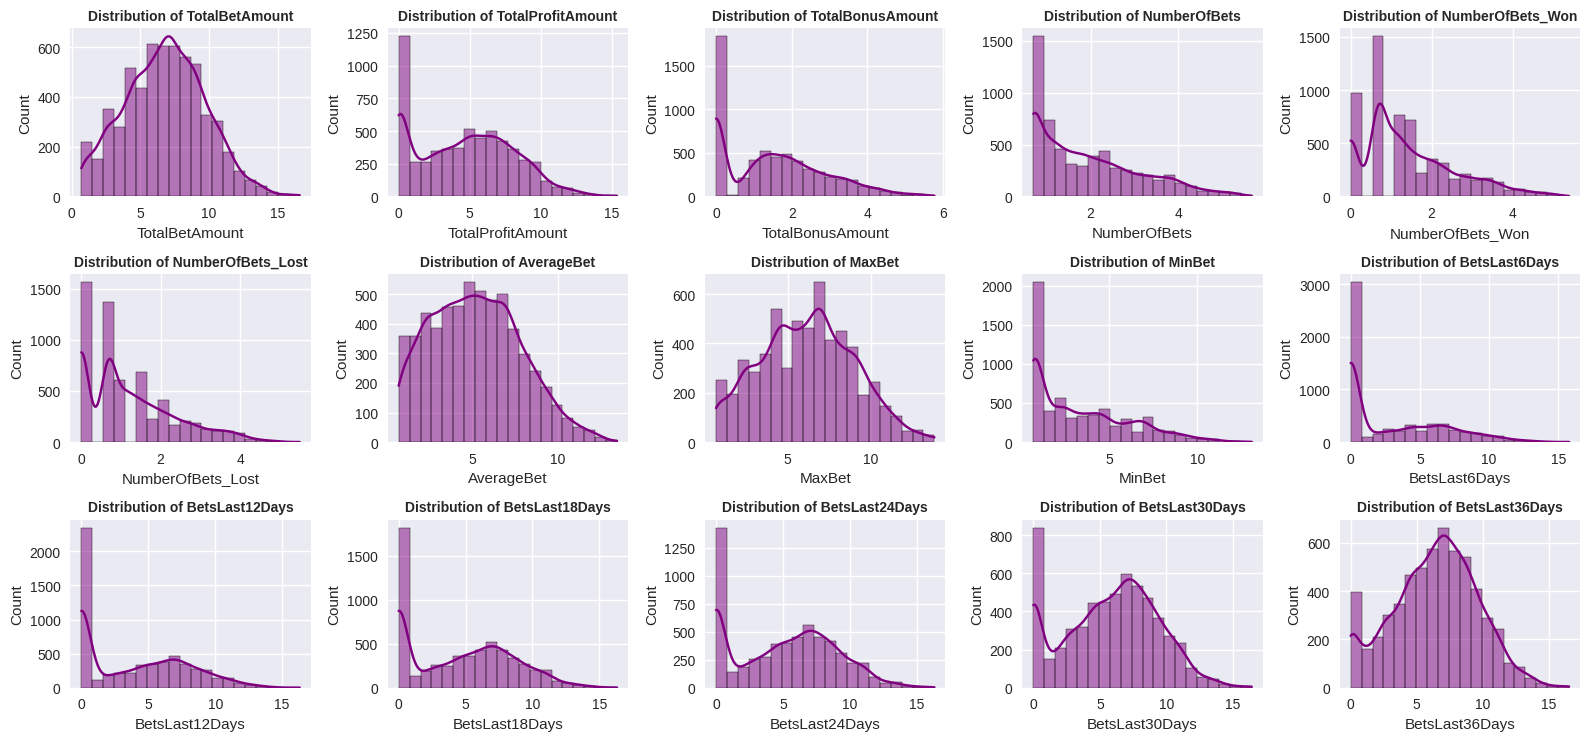

In [85]:
# Plot histograms for all numerical features
plt.figure(figsize=(16, 12))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(5, 5, i)  # Adjust grid size as needed
    sns.histplot(data=over_sampling_df_transform, x=feature, kde=True, bins=20, color='purple')
    plt.title(f'Distribution of {feature}', fontsize=10, weight='bold')
plt.tight_layout()
plt.show()

In [86]:
over_sampling_df_transform[cols_to_scale] = scaler.fit_transform(over_sampling_df_transform[cols_to_scale])

In [87]:
X = over_sampling_df_transform
y = df_test_over['Churned']

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

In [89]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=3,  # previously 100
    batch_size=2, # previously 32
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/3
2370/2370 [==============================] - 14s 6ms/step - loss: 0.0878 - accuracy: 0.9681 - val_loss: 0.0391 - val_accuracy: 0.9966
Epoch 2/3
2370/2370 [==============================] - 11s 5ms/step - loss: 0.0711 - accuracy: 0.9719 - val_loss: 0.0284 - val_accuracy: 0.9975
Epoch 3/3
2370/2370 [==============================] - 12s 5ms/step - loss: 0.0606 - accuracy: 0.9721 - val_loss: 0.0196 - val_accuracy: 0.9975


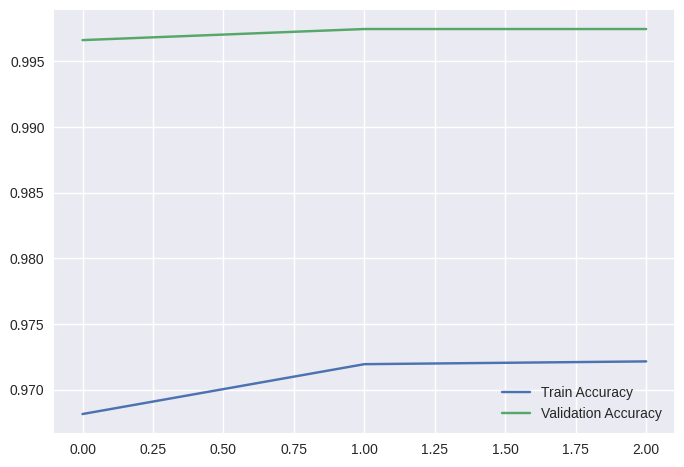

38/38 [==============================] - 0s 7ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       583
           1       1.00      1.00      1.00       602

    accuracy                           1.00      1185
   macro avg       1.00      1.00      1.00      1185
weighted avg       1.00      1.00      1.00      1185

Confusion Matrix:
 [[580   3]
 [  0 602]]


In [90]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Predictions (convert probabilities to binary)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Text(95.72222222222221, 0.5, 'Truth')

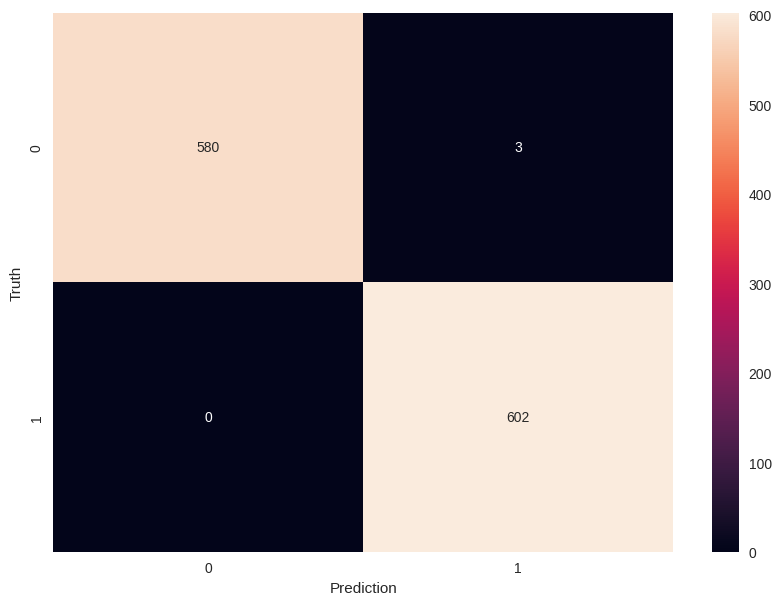

In [91]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

plt.figure(figsize= (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')